In [1]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load GloVe embeddings using the 6B 50D embeddings already downloaded on Patas
with open('data\\glove.6B.50d.txt', encoding="utf8") as infile:
        lines = infile.readlines() 

glove_embeddings = {} # dictionary that maps words to embeddings (NP arrays)

for line in lines:
    line = line.strip().split() 
    word = line[0]
    nums = [float(x) for x in line[1:]]
    vector = torch.FloatTensor(nums)
    glove_embeddings[word] = vector 


In [3]:
glove_embeddings['car']

tensor([ 0.4769, -0.0846,  1.4641,  0.0470,  0.1469,  0.5082, -1.2228, -0.2261,
         0.1931, -0.2976,  0.2060, -0.7128, -1.6288,  0.1710,  0.7480, -0.0619,
        -0.6577,  1.3786, -0.6804, -1.7551,  0.5832,  0.2516, -1.2114,  0.8134,
         0.0948, -1.6819, -0.6450,  0.6322,  1.1211,  0.1611,  2.5379,  0.2485,
        -0.2682,  0.3282,  1.2916,  0.2355,  0.6147, -0.1344, -0.1324,  0.2740,
        -0.1182,  0.1354,  0.0743, -0.6195,  0.4547, -0.3032, -0.2188, -0.5605,
         1.1177, -0.3659])

In [4]:
# Read data as PD dataframe
df = pd.read_csv("data\\split_data\\train_dataset.csv")
df.head(n=10)

,Unnamed: 0,text,target
0,0,A mother who repeatedly told health profession...,0
1,1,"According to her , she established Royal Seed ...",1
2,2,Political mercenaries were once again in hot d...,0
3,3,In a major step towards providing Universal He...,0
4,4,"Fortunately , the funding of the exhibition ha...",0
5,5,""" Data centers are especially vulnerable here ...",0
6,6,The number of children taking up smoking and w...,0
7,7,Every young person will one day have life-chan...,0
8,8,Vikran Patel CBS TV in an interview titled ' 6...,0
9,9,""" Then I tried taking the bus around town , it...",0


In [5]:
def undersampling(data, target_column='target'):
    # Split the data into positive and negative samples
    positive_samples = data[data[target_column] == 1]
    negative_samples = data[data[target_column] == 0]
    
    # Find the number of samples in the smallest class
    num_positive = positive_samples.shape[0]
    
    # Sample from the negative samples to get a random subset equal to the number of positive samples
    negative_subset = negative_samples.sample(n=num_positive, random_state=42)
    
    # Concatenate the balanced datasets
    balanced_data = pd.concat([positive_samples, negative_subset])
    
    # Shuffle the dataset to mix positive and negative samples
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_data

df = undersampling(df)
df.head(n=10)

,Unnamed: 0,text,target
0,611,The hundreds of families that have gathered at...,1
1,7609,"However , despite Fianna F ? il arguing the mo...",0
2,3034,We have good reason to believe that the number...,0
3,621,The Minister for Disability Issues Carmel Sepu...,0
4,8338,""" So instead of recrimination , let us join ha...",1
5,5356,Americans are more likely to die from their cl...,0
6,2240,""" The processing on this coffee is different t...",0
7,2664,"Back to the commercial , the artists mentioned...",1
8,1175,""" He just walked right up to me and said , ' H...",0
9,6504,Secondary sub-menu <h> About 40 evacuated from...,0


In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

sw = stopwords.words('english')

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Removing html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = " ".join(text) #removing stopwords

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    return text

df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,Unnamed: 0,text,target
0,611,hundreds families gathered enormous nrg centre...,1
1,7609,"however , despite fianna f il arguing move wou...",0
2,3034,good reason believe number bangladeshis among ...,0
3,621,minister disability issues carmel sepuloni min...,0
4,8338,"instead recrimination , let us join hands comm...",1


In [7]:
train_sentences = df.text.values
train_labels = df.target.values

print(len(train_sentences))
print(len(train_labels))

train_sentences = [word_tokenize(sentence) for sentence in train_sentences]

print(train_sentences[0])

1776
1776
['hundreds', 'families', 'gathered', 'enormous', 'nrg', 'centre', 'southern', 'outskirts', 'houston', 'may', 'roof', 'heads', ',', 'plight', 'similar', 'left', 'middle', 'east', 'europe', 'refugees', 'people', 'lost', 'homes', ',', 'possessions', ',', 'many', 'cases', ',', 'livelihoods']


In [8]:
# get vectors for each data point

def get_vectors(glove_vector, sentences, labels):
    dataset = []
    for i, line in enumerate(sentences):
        vector_sum = torch.zeros(50)
        if len(line) > 0:
            for w in line:
                # if i == 0:
                #     print(w)
                #     print(glove_vector[w])
                #     print(len(line))
                if w in glove_vector: # ignore out of vocabulary words for now
                    vector_sum += glove_vector[w] 
    
            aggregate_vector = vector_sum / len(line) # use mean as a sentence aggregate (sentence2vec)
            aggregate_vector = aggregate_vector.view(1, 50)
                
        label = torch.tensor(labels[i]).long()
        dataset.append((aggregate_vector, label))
            
    return dataset

dataset = get_vectors(glove_embeddings, train_sentences, train_labels)

# i=0
# for vector, label in dataset:
#     if not isinstance(label, torch.Tensor):
#         print("Label is not a tensor")
#     if not isinstance(vector, torch.Tensor):
#         print("Vector is not a tensor")
#         print(i)
#         print(dataset[i])
#     i += 1

print(dataset[2][0].shape)

torch.Size([1, 50])


In [9]:
# Do a 80-20 train/validation split

from torch.utils.data import random_split


train_size = int(0.8 * len(dataset))
val_size = len(dataset)  - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,420 training samples
  356 validation samples


In [10]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)

batch_size = 128

# Create the DataLoaders for our training and validation sets.
train_loader = torch.utils.data.DataLoader(
            train_dataset,  # The training samples.
            sampler = torch.utils.data.RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

valid_loader = torch.utils.data.DataLoader(
            val_dataset, # The validation samples.
            sampler = torch.utils.data.SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


# Check the shape of the data batch
for data, target in train_loader:
    print(data.shape)  # Should output torch.Size([128, 1, 50])
    break

torch.Size([128, 1, 50])


In [11]:

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for lines, targets in train_loader:
            lines, targets = lines.to(device), targets.to(device) 

            # print("lines")
            # print(lines.size())
            # print("targets")
            # print(targets.size())
            
            optimizer.zero_grad()
            pred = model(lines)

            # print("Output shape:", pred.shape)  # Debugging line
            # print("Target shape:", targets.shape)  # Debugging line
            
            loss = criterion(pred, targets)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))     

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for lines, targets in data_loader:
        lines, targets = lines.to(device), targets.to(device)
        
        output = model(lines)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(targets.view_as(pred)).sum().item()
        total += targets.shape[0]
    return correct / total

Epoch 1; Loss 0.711271; Train Acc 0.466197; Val Acc 0.497191
Epoch 2; Loss 0.700084; Train Acc 0.457746; Val Acc 0.455056
Epoch 3; Loss 0.708797; Train Acc 0.473944; Val Acc 0.469101
Epoch 4; Loss 0.682808; Train Acc 0.485211; Val Acc 0.505618
Epoch 5; Loss 0.688275; Train Acc 0.480986; Val Acc 0.491573
Epoch 6; Loss 0.728498; Train Acc 0.473239; Val Acc 0.463483
Epoch 7; Loss 0.688455; Train Acc 0.485211; Val Acc 0.485955
Epoch 8; Loss 0.695869; Train Acc 0.485211; Val Acc 0.477528
Epoch 9; Loss 0.680187; Train Acc 0.503521; Val Acc 0.522472
Epoch 10; Loss 0.739686; Train Acc 0.493662; Val Acc 0.494382
Epoch 11; Loss 0.686620; Train Acc 0.497887; Val Acc 0.505618
Epoch 12; Loss 0.706186; Train Acc 0.515493; Val Acc 0.508427
Epoch 13; Loss 0.712235; Train Acc 0.535211; Val Acc 0.471910
Epoch 14; Loss 0.684442; Train Acc 0.521831; Val Acc 0.508427
Epoch 15; Loss 0.689713; Train Acc 0.537324; Val Acc 0.502809
Epoch 16; Loss 0.680919; Train Acc 0.557746; Val Acc 0.519663
Epoch 17; Loss 0.

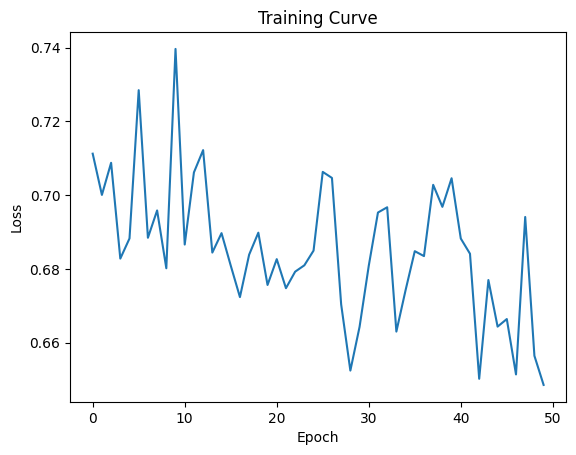

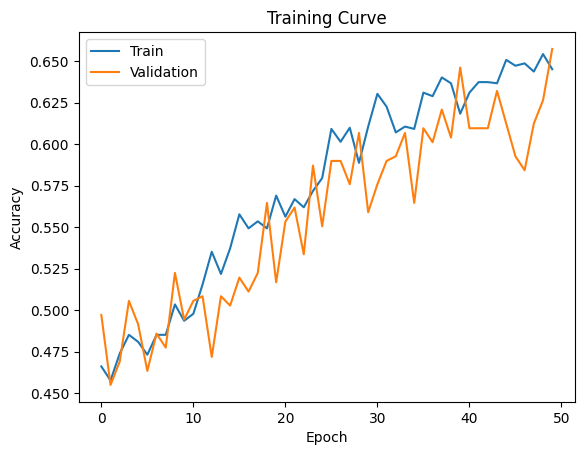

In [13]:
# model = nn.Sequential(nn.Linear(50, 40),
#                         nn.ReLU(),
#                         nn.Linear(40, 20),
#                         nn.ReLU(),
#                         nn.Linear(20, 2))


model = nn.Sequential(nn.Dropout(p=0.2),
                      nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, padding=1),
                      nn.MaxPool1d(2),
                      nn.Flatten(),
                      nn.Linear(5*25, 2)
                     )

# enable gradient checkpointing to avoid out of memory with GPU training
# model.gradient_checkpointing_enable()

model = model.to(device)

# train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-4)

# optimizer = torch.utils.data.AdamW(model.parameters(),
#                   lr = 1e-4, 
#                   eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                 )



train_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-4)



In [14]:
# Read, clean, and tokenize test data
test_df = pd.read_csv("data\\split_data\\dev_dataset.csv")
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))
test_sentences = test_df.text.values
test_labels = test_df.target.values
test_sentences = [word_tokenize(sentence) for sentence in test_sentences]

print(len(test_sentences))
print(len(test_labels))

test_dataset = get_vectors(glove_embeddings, test_sentences, test_labels)

print(test_sentences[0])
print(test_dataset[0])

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


1047
1047
['latest', 'illiberal', 'moves', 'part', 'turkish', 'government', 'increased', 'tensions', 'turkey', 'european', 'union', ',', 'putting', 'ongoing', 'negotiations', 'granting', 'turkish', 'nationals', 'visa', 'free', 'entry', 'schengen', 'area', 'jeopardy', 'visa', 'deal', 'danger', 'falling', 'apart', 'turkey', 'refusal', 'change', 'anti', 'terror', 'laws', ',', 'european', 'union', 'feared', 'used', 'journalists', 'government', 'critics', 'constitutional', 'amendment', 'may', 'sealed', 'fate', 'negotiations', 'could', 'derail', 'refugee', 'pact', ',', 'eu', 'agreed', 'compensate', 'turkey', 'billion', 'return', 'containing', 'flow', 'syrian', 'refugees', 'europe']
(tensor([[ 0.2536, -0.0440,  0.0116, -0.1455, -0.0104,  0.1775, -0.1846,  0.0337,
          0.0320, -0.1326,  0.1740, -0.1764, -0.1679,  0.0922,  0.4286,  0.3304,
          0.2434, -0.3907,  0.1254, -0.0276,  0.2713, -0.0680, -0.1315, -0.0278,
         -0.1244, -1.4654,  0.2191, -0.0888,  0.1193,  0.2301,  2.6275,

In [15]:
# test

predictions = []

for lines, targets in test_loader:
    lines, targets = lines.to(device), targets.to(device) 
    output = model(lines)
    pred = output.max(1, keepdim=True)[1]

    predictions.extend(list(pred.flatten()))

predictions = [pred.item() for pred in predictions]

with open('Glove_NN_outputs_withUndersampling.txt', 'w') as outfile:
    for prediction in predictions:
        outfile.write(str(prediction) + '\n')